# 121_feature_importance.ipynb
Runs feature importance algorithm for the given model.

In [ ]:
from pathlib import Path
path = Path.cwd().parent.parent

# Setup parameters for each type of simulation
SETUP = {'PC1': {'X': path / "data" / "interim" / "pc_by_feature_group_for_patients.csv",
                 'hyperparameters_file' : path / "notebooks" / "modeling" / "optimal_params_pc1.json"},
        'PC1_3' : {'X' : path / "data" / "interim" / "pc1_to_3_by_feature_group_for_patients.csv",
                   'hyperparameters_file' : path / "notebooks" / "modeling" / "optimal_params_pc1_to_3.json"},
        'ALL_IMG' : {'X' : path / "data" / "raw" / "imagingFeatures.csv",
                     'hyperparameters_file' : path / "notebooks" / "modeling" / "optimal_params_all_image_features.json"}}

# Each of the models uses a different input- so choose the model that we would like
# to run for this chosen version
MODEL = 'ALL_IMG'

# What we would like to predict
TARGET = 'Mol Subtype'

In [18]:
# Factors: PC1 for each of the ten feature groups
# Predictor: Molecular Subtype
import pandas as pd
from sklearn.preprocessing import LabelEncoder

trainPatientID = (pd.read_csv(path / "data" / "processed" / "trainDataPatientID.csv")
                  .drop(['Unnamed: 0'], axis=1)
                  .rename(columns={'Patient.ID' : 'Patient ID'}, errors='ignore'))

# Fetch the feature data
features = pd.read_csv(SETUP[MODEL]['X'])
features.rename(columns={'Patient.ID': 'Patient ID'}, inplace=True, errors='ignore')
features = features[features['Patient ID'].isin(trainPatientID['Patient ID'])]

# Fetch the outcome data
clin = pd.read_csv(path / "data" / "raw" / "clinicalData_clean.csv")
clin = clin[clin['Patient ID'].isin(trainPatientID['Patient ID'])]

# Merge feature with relevant outcome
data = features.merge(clin[['Patient ID', TARGET]], on='Patient ID', how='inner')
data = data.drop('Unnamed: 0', axis=1, errors='ignore')

# Select only the desired outcome, convert to factor if needed
y = data[TARGET]
if y.dtype == 'object' or y.dtype.name == 'category':
    le = LabelEncoder()
    y = le.fit_transform(y)# Drop the target and patient ID columns to get the feature set
X = data.drop([TARGET, 'Patient ID'], axis=1, errors='ignore')
X

,"F1_DT_POSTCON (T11=0.05,T12=0.5)","F1_DT_POSTCON (T11=0.05,T12=0.1)","F1_DT_POSTCON (T11=0.02,T12=0.5)","F1_DT_POSTCON (T11=0.02,T12=0.8)","F1_DT_POSTCON (T11=0.05,T12=0.8)","F1_DT_POSTCON (T11=0.1,T12=0.5)","F1_DT_POSTCON (T11=0.1,T12=0.8)","F1_DT_POSTCON (T11=0.2,T12=0.5)","F1_DT_POSTCON (T11=0.2,T12=0.8)","F1_DT_T1NFS (T11=0.05,T12=0.5)",...,WashinRate_map_difference_entropy_tissue_PostCon,WashinRate_map_information_measure_correlation1_tissue_PostCon,WashinRate_map_information_measure_correlation2_tissue_PostCon,WashinRate_map_inverse_difference_is_homom_tissue_PostCon,WashinRate_map_inverse_difference_normalized_tissue_PostCon,WashinRate_map_inverse_difference_moment_normalized_tissue_PostCon,WashinRate_map_mean_tissue_PostCon,WashinRate_map_std_dev_tissue_PostCon,WashinRate_map_skewness_tissue_PostCon,WashinRate_map_kurtosis_tissue_PostCon
0,1.000000,0.129546,0.485217,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,0.432916,...,3.444474,-0.036063,0.505652,0.177087,0.959067,0.996363,47.297950,83.909561,0.251498,5.659428
1,0.174775,0.062051,0.069910,0.132265,0.330662,0.349550,0.661324,0.699100,1.00000,0.185670,...,3.478455,-0.043730,0.546674,0.170507,0.957527,0.995981,114.171582,129.252343,1.928743,11.554948
2,0.289669,0.052031,0.115868,0.378575,0.839984,0.579338,1.000000,0.958287,1.00000,0.392859,...,4.009938,-0.049294,0.603426,0.117966,0.930624,0.989135,34.406635,26.951415,0.985464,4.331451
3,0.917296,0.086009,0.733451,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,0.918007,...,3.594053,-0.097129,0.756073,0.175340,0.953562,0.994800,30.764137,25.431670,1.017298,4.053362
4,0.394897,0.078257,0.157959,0.381583,1.000000,0.795967,1.000000,1.000000,1.00000,0.358085,...,3.120068,-0.036613,0.489192,0.226712,0.970177,0.997823,8.285542,17.979496,0.755070,9.399109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683,0.161342,0.060613,0.064537,0.119131,0.297827,0.322684,0.595654,0.645369,1.00000,0.227489,...,3.537207,-0.040083,0.536215,0.165048,0.955230,0.995555,67.336408,108.323843,1.180897,6.357979
684,0.091844,0.050240,0.036738,0.103783,0.259457,0.183688,0.518915,0.367377,0.90289,0.125807,...,3.948053,-0.090354,0.754825,0.135670,0.935277,0.989856,591.035965,397.002913,0.449477,2.857014
685,0.587345,0.115746,0.234938,0.479802,1.000000,1.000000,1.000000,1.000000,1.00000,0.336273,...,3.116735,-0.050326,0.565456,0.223324,0.970250,0.997982,30.665570,65.018278,1.563114,12.928674
686,0.742209,0.058729,0.296884,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,0.609958,...,3.369220,-0.050465,0.572790,0.178169,0.961318,0.996820,17.724748,18.299932,2.282520,13.460166


In [21]:
# Fetch the optimal hyperparameters for this model
import json
with open(SETUP[MODEL]['hyperparameters'], 'r') as file:
    model_info = json.load(file)

# Print the data
print(model_info)

JSONDecodeError: Extra data: line 2 column 1 (char 5022)

## Permutation importance by feature group
* Used to determine how much a model's performance relies on each feature
* Works by shuffling the values of a feature and observing the impact on the model's error rate
* A large increase in the error while shuffling indicates the feature is important, while little to no change suggests that it is not

In [3]:
from sklearn.ensemble import RandomForestClassifier

best_rf_params = {"bootstrap": True, 
                "max_depth": 10,
                "min_samples_leaf": 4,
                "min_samples_split": 5,
                "n_estimators": 500}

rf = RandomForestClassifier(**best_rf_params)
rf.fit(X, y)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=500)

In [ ]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance
result = permutation_importance(
    rf, X, y,
    n_repeats=10, # number of times to shuffle each feature
    random_state=42,
    n_jobs=-1 # use all CPU cores
)

In [ ]:
# Get feature names
feature_names = X.columns

# Create a DataFrame for easy viewing
importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': result.importances_mean, # average drop in accuracy when the feature is shuffled
    'importance_std': result.importances_std # standard deviation across repeats
}).sort_values(by='importance_mean', ascending=False)

print(importances_df)

                                       feature  importance_mean  \
0      PC1_Combining_Tumor_and_FGT_Enhancement         0.039371   
8                  PC1_FGT_Enhancement_Texture         0.035033   
4              PC1_Tumor_Enhancement_Variation         0.034707   
2                PC1_Tumor_Enhancement_Texture         0.033948   
7                        PC1_Tumor_Enhancement         0.033731   
9                PC1_FGT_Enhancement_Variation         0.033406   
6                          PC1_FGT_Enhancement         0.031128   
1                PC1_Tumor_Size_and_Morphology         0.027223   
5           PC1_Breast_and_FGT_Volume_Features         0.027007   
3  PC1_Tumor_Enhancement_Spatial_Heterogeneity         0.026247   

   importance_std  
0        0.003070  
8        0.001882  
4        0.003757  
2        0.002992  
7        0.002805  
9        0.002158  
6        0.002912  
1        0.002763  
5        0.002398  
3        0.002603  


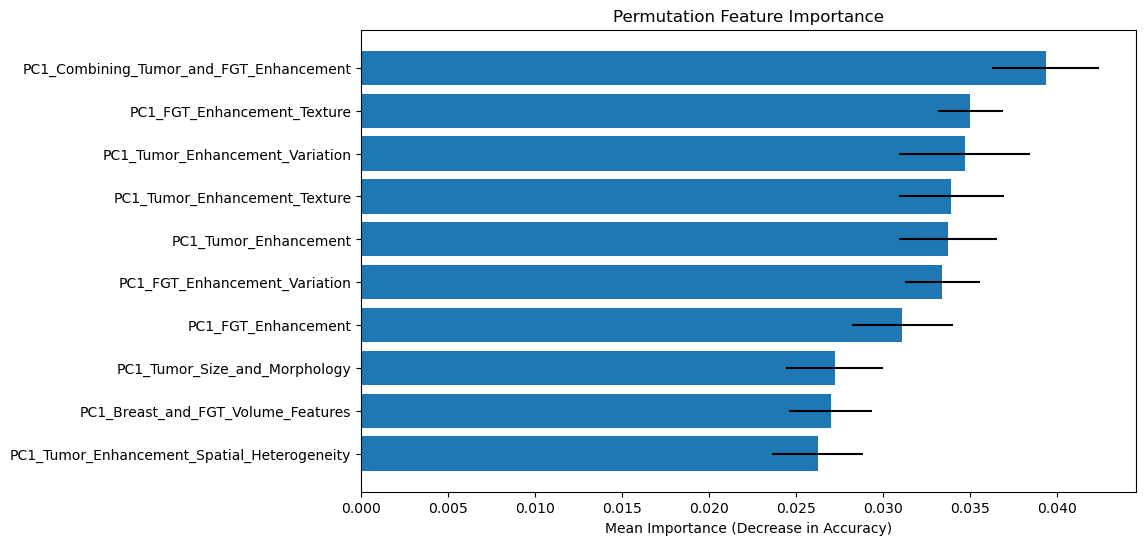

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(importances_df['feature'], importances_df['importance_mean'], xerr=importances_df['importance_std'])
plt.xlabel('Mean Importance (Decrease in Accuracy)')
plt.title('Permutation Feature Importance')
plt.gca().invert_yaxis()
plt.show()